<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




**Comparative** Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location & Import Dependencies

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [ ]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import cv2
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
import pandas as pd
from IPython.display import HTML, display
import time
import gc
import random
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

"""
Seeding to achieving consistent results across training and inference sessions.
"""

# Seed value
seed_value = 42

# Set python built-in pseudo-random generator
random.seed(seed_value)

# Set numpy pseudo-random generator
np.random.seed(seed_value)

# Set tensorflow pseudo-random generator
tf.random.set_seed(seed_value)

# Set PYTHONHASHSEED environment variable
os.environ['PYTHONHASHSEED'] = str(seed_value)


base_directory = '/content/drive/MyDrive/VideoAnomalyDetection/'
base_dataset_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'
saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'
train_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train_2.txt'
test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'
checkpoint_dir = "/content/drive/MyDrive/VideoAnomalyDetection/training_1"
checkpoint_prefix = '/content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711678818'
output_dir = '/content/drive/MyDrive/VideoAnomalyDetection/output/preprocessed_videos'
segments_dir = '/content/drive/MyDrive/VideoAnomalyDetection/output/preprocessed_videos'

## Define Video Processing Utilities

In [ ]:
def read_video_paths_from_file(file_path, base_dataset_dir):
    full_file_path = os.path.join(base_dataset_dir, file_path)

    with open(full_file_path, 'r') as file:
        # Concatenate base_dataset_dir with each path read from the file
        paths = [os.path.join(base_dataset_dir, line.strip()) for line in file]

    return paths

def filter_video_paths(paths, filter_keyword):
    return [path for path in paths if filter_keyword.lower() in path.lower()]


def filter_video_paths_by_anomaly_type(paths, anomaly_type):
    """Filter video paths based on a specific anomaly type."""
    return [path for path in paths if anomaly_type.lower() in path.lower()]
import os
import cv2

def can_read_file(filepath):
    """
    This function checks the existence of the file and optionally its extension.

    Parameters:
    - filepath: Path to the video file.

    Returns:
    - bool: True if the file exists and has a video file extension; False otherwise.
    """
    # List of common video file extensions for basic filtering.
    video_extensions = ['.avi', '.mp4', '.mov', '.mkv']

    if not os.path.exists(filepath) or not os.path.isfile(filepath):
        return False

    # Check if the file extension is in the list of video extensions.
    file_extension = os.path.splitext(filepath)[1].lower()
    if file_extension not in video_extensions:
        return False

    return True

def list_video_files(directory, extension='mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
     # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory does not exist - {directory}")
        return []  # Return an empty list instead of None

    # Check if the directory can be accessed (read permissions)
    if not os.access(directory, os.R_OK):
        print(f"Error: Directory cannot be read, check permissions - {directory}")
        return []  # Return an empty list instead of None

    # Perform a recursive search for video files
    pattern = os.path.join(directory, '**', f'*.{extension}')
    _video_files = glob.glob(pattern, recursive=True)
    return _video_files


def shuffle_together(video_paths, labels):
    """
    Shuffle two lists in unison.

    Parameters:
    - video_paths: The first list to shuffle.
    - label: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled video_paths and label.
    """
    if len(video_paths) != len(labels):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    video_paths_shuffled, label_shuffled = shuffle(video_paths, labels)
    return video_paths_shuffled, label_shuffled

def get_total_frames(video_path):
    """
    Returns the total number of frames in a video.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - The total number of frames as an integer.
    """
    # Initialize the video capture object with the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return 0  # Indicates that the video could not be opened

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return total_frames

def segments_per_video(video_path, segment_length=32):
    total_frames = get_total_frames(video_path)  # This function needs to return the total frame count
    segments = 0
    if total_frames != 0:
          segments = total_frames // segment_length
          if total_frames % segment_length != 0:
              segments += 1  # Account for the last, potentially shorter, segment
    print("{} frames, {} segments for {}".format(total_frames,segments,video_path))
    return segments

def ensure_correct_dimensions(video_data, labels):
    # Now the function directly accepts video_data and labels as separate arguments

    # Define the expected shape, excluding batch size to allow dynamic sizes
    expected_shape = (32, 224, 224, 3)  # Example: (segments, height, width, channels)

    # Ensure the shape of the video data matches the expected shape, excluding the batch size
    tf.debugging.assert_equal(tf.shape(video_data)[1:], expected_shape, message="Video batch dimensions are incorrect")

    # Return video_data and labels unchanged
    return video_data, labels

def count_segments(segments_dir):
    # Count all files that match the segment pattern
    segment_files = glob.glob(os.path.join(segments_dir, '*_segment_*.npy'))
    return len(segment_files)

def cleanup_cache_files(pattern):
    files_to_delete = glob.glob(pattern)
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted: {file}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")


# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [ ]:
def save_unique_file(segment_path, segment_data):
    """
    Checks if the file already exists. If it does not, saves the file; otherwise, skips saving.
    """
    # Check if the file exists
    if not os.path.exists(segment_path):
        # Save the file if it does not exist
        np.save(segment_path, segment_data)
    else:
        # Optionally, log or print a message indicating the file exists and will not be overwritten
        print(f"File {segment_path} already exists. Skipping save.")

# Preprocess videos on-the-fly for inference
def preprocess_and_segment_video(video_input, resize_shape=(224, 224), segment_length=32):
    frames = []
    is_video_file = isinstance(video_input, str)

    if is_video_file:
        if not os.path.exists(video_input):
            print(f"File does not exist: {video_input}")
            return
        if not can_read_file(video_input):
            print(f"Cannot read file: {video_input}")
            return

        try:
            cap = cv2.VideoCapture(video_input)
            if not cap.isOpened():
                raise IOError(f"OpenCV could not open video file for an unknown reason: {video_input}")
        except Exception as e:
            print(f"Error: {e}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

        cap.release()
    elif isinstance(video_input, (list, np.ndarray)):
        # Additional check for non-empty list/array
        if len(video_input) == 0:
            print("The list/array of frames is empty.")
            return

        frames = video_input
    else:
        raise ValueError("Invalid type for video_input. Must be a file path or list/array of frames.")

    # Segmenting the frames
    for i in range(0, len(frames), segment_length):
        segment_frames = frames[i:i+segment_length]
        if len(segment_frames) < segment_length:
            segment_frames.extend([np.zeros(resize_shape + (3,), dtype=np.float32) for _ in range(segment_length - len(segment_frames))])
        yield np.stack(segment_frames, axis=0)

# Preprocess videos offline before training
def preprocess_video_and_save_segments(video_input, label, output_dir, video_id, resize_shape=(224, 224), segment_length=32):
    frames = []
    is_video_file = isinstance(video_input, str)

    if is_video_file:
        if not os.path.exists(video_input):
            print(f"File does not exist: {video_input}")
            return
        if not can_read_file(video_input):
            print(f"Cannot read file: {video_input}")
            return

        try:
            cap = cv2.VideoCapture(video_input)
            if not cap.isOpened():
                raise IOError(f"OpenCV could not open video file for an unknown reason: {video_input}")
        except Exception as e:
            print(f"Error: {e}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

        cap.release()
    elif isinstance(video_input, (list, np.ndarray)):
        # Additional check for non-empty list/array
        if len(video_input) == 0:
            print("The list/array of frames is empty.")
            return

        frames = video_input
    else:
        raise ValueError("Invalid type for video_input. Must be a file path or list/array of frames.")

    segment_count = 0  # For naming segments uniquely
    for i in range(0, len(frames), segment_length):
        segment_frames = frames[i:i+segment_length]
        if len(segment_frames) == segment_length or (len(segment_frames) < segment_length and i + segment_length > len(frames)):
            if len(segment_frames) < segment_length:
                # Pad the last segment with zeros if it has fewer frames
                segment_frames += [np.zeros(resize_shape + (3,), dtype=np.float32)] * (segment_length - len(segment_frames))

            segment_path = os.path.join(output_dir, f"{video_id}_segment_{segment_count}.npy")
            label_path = segment_path.replace('.npy', '_label.npy')

            # Use the new function to save files with unique names
            save_unique_file(segment_path, np.array(segment_frames))
            save_unique_file(label_path, np.array([label]))

            segment_count += 1

## Preprocess and Save Training Dataset

In [ ]:
# Read video paths from the file
video_paths = read_video_paths_from_file(train_file_path,base_dataset_dir)

# Use "Shooting" and "Normal" to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')

video_paths = anomaly_videos + normal_videos

# Annotate anomalous and normal videos
labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)
print("\nvideo paths {} and labels {}".format(video_paths,labels))
video_paths, labels = shuffle_together(video_paths, labels)
print("\nShuffled: video paths {} and labels {}".format(video_paths,labels))


# Looping through each video path
for video_path, label in zip(video_paths, labels):
    video_id = video_path.split("/")[-1].split(".")[0]
    print('video_id',video_id)
    preprocess_video_and_save_segments(video_path, label, output_dir,video_id)



video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos002_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4'] and labels [1, 1, 1, 0, 0, 0]

Shuffled: video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4', '/content/drive/MyDrive/VideoAnoma

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Preprocessed and segmented videos from Disk

In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob

def read_video_list(file_path):
    """
    Read the list of video segments from a text file.
    """
    with open(file_path, 'r') as file:
        video_list = file.read().splitlines()
    return video_list

def load_segment_and_label(segment_path):
    """
    Load a single segment and its corresponding label from disk.
    """
    base_path_without_extension = segment_path.rsplit('.', 1)[0]
    label_path = f"{base_path_without_extension}_label.npy"

    # Load segment
    segment = np.load(segment_path)
    label = np.load(label_path)
    #print("Loading segment from:", segment_path)
    #print("Loading label from:", label_path)
    if label.shape[0] == 1:
        label = label[0]
    return segment, label

def segment_label_generator(segments_dir, video_list):
    """
    Generator that yields segment and label pairs for specified videos.
    """
    #print('segment_label_generator')
    #print('video_list', video_list)
    # Build a list of paths for the segments to load
    segment_paths_to_load = [
        os.path.join(segments_dir, os.path.basename(video_name).replace('.mp4', '_segment_*.npy'))
        for video_name in video_list
    ]

    #print('segment_paths_to_load', segment_paths_to_load)

    # Find all matching segment files
    all_files = []
    for pattern in segment_paths_to_load:
        all_files.extend(glob.glob(pattern))

    # Filter out label files
    segment_paths = [path for path in all_files if "_label" not in path]

    #print('segment_paths', segment_paths)

    for segment_path in segment_paths:
        segment, label = load_segment_and_label(segment_path)
        yield segment, label

def create_dataset_from_saved_segments(file_path, segments_dir, batch_size=32):
    """
    Create a TensorFlow dataset of segments and labels using a generator.
    """
    # Read the video list from the file
    video_list = read_video_list(file_path)
    #print('video_list',video_list)
    output_signature = (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: segment_label_generator(segments_dir, video_list),
        output_signature=output_signature
    )

    return dataset

train_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train_2.txt'
segments_dir = '/content/drive/MyDrive/VideoAnomalyDetection/output/preprocessed_videos'
dataset = create_dataset_from_saved_segments(train_file_path, segments_dir)

'''
for segment, label in dataset.take(2):
    print("Segment shape:", segment.shape)
    print("Label:", label)
'''

'\nfor segment, label in dataset.take(2):\n    print("Segment shape:", segment.shape)\n    print("Label:", label)\n'

## Fine-Tune 'Video Swin Transformer' Pretrained Model

In [ ]:
def build_finetune_model():
    """
    Fine-tune pretrained model.

    Parameters:
        saved_model_path (str): Path to the saved Video Swin Transformer model.

    Returns:
        model (keras.Model): Fine-tuned model for shooting classification.
    """
    # Load the pretrained Video Swin model
    video_swin = load_model(saved_model_path, compile=False)

    # Fine-tuning configuration: set the last N layers to be trainable
    # N=1, fine-tune the last layer of the pretrained model
    """
    N=1
    for layer in video_swin.layers[:-N]:
        layer.trainable = False
    for layer in video_swin.layers[-N:]:
        layer.trainable = True
    """
    # Set the entire Video Swin model to non-trainable
    video_swin.trainable = False

    # Downstream model for binary classification
    model = Sequential([
        video_swin,
        # Assume video_swin's output shape is compatible with the Dense layer's input
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization again if needed
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    return model


## Define Call-Back Operations for Model Training

In [ ]:
# Define the base directory to save checkpoints
model_chkpt_filename = f"training_1/vad_{int(time.time())}.ckpt"
checkpoint_path = os.path.join(base_directory, model_chkpt_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create the base directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Callbacks configuration
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'),  # Save the best model based on val_loss
    EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=1),  # Stop training when `val_loss` is no longer improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=1),  # Reduce learning rate when `val_loss` plateaus
    TensorBoard(
        log_dir=os.path.join(base_directory, 'logs'),  # Path to save log files for TensorBoard in Google Drive
        histogram_freq=1,  # Record activation histograms every 1 epoch
        embeddings_freq=1)  # Record embedding data every 1 epoch
]


# Define a custom callback for clearing the session and collecting garbage
class ClearSessionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

# Assume `callbacks_list` is already defined. Add the new callback to it.
callbacks_list.append(ClearSessionCallback())

## Define Custom MIL (Multiple Instance Loss)

In [ ]:
def mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01, margin=5.0):
    """
    MIL ranking loss with sparsity and smoothness constraints.

    Args:
    - sparsity_weight: Weight for the sparsity term.
    - smoothness_weight: Weight for the smoothness term.
    - margin: Margin for the ranking loss.

    Returns:
    - A loss function that takes (y_true, y_pred) as inputs.
    """

    def loss(y_true, y_pred):
        # Separate the anomaly scores into positive and negative samples based on the labels.
        positive_scores = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        negative_scores = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        # Calculate the highest scores for positive and negative samples.
        highest_positive_score = tf.reduce_max(positive_scores)
        highest_negative_score = tf.reduce_max(negative_scores)

        # Calculate ranking loss.
        ranking_loss = tf.maximum(0.0, margin - highest_positive_score + highest_negative_score)

        # Calculate sparsity loss (L1 norm of the predictions).
        sparsity_loss = tf.reduce_sum(tf.abs(y_pred))

        # Calculate smoothness loss (squared difference between adjacent anomaly scores).
        diffs = y_pred[:, 1:] - y_pred[:, :-1]
        smoothness_loss = tf.reduce_sum(tf.square(diffs))

        # Combine the losses using the weights and loss components.
        total_loss = ranking_loss + (sparsity_weight * sparsity_loss) + (smoothness_weight * smoothness_loss)

        return total_loss

    return loss

## Split Dataset into Training & Validation Set. Define Data Generators & Set Training Parameters.

In [ ]:
total_segments_actual = count_segments(segments_dir)
batch_size = 32  # Assuming you've defined a batch size
steps_per_epoch = np.ceil(total_segments_actual / batch_size)
print(f"\nTotal segments across all videos: {total_segments_actual}")

# Calculate split sizes
train_data_size = int(total_segments_actual * 0.8)
print("\nTraining size split into :", train_data_size)
val_data_size = total_segments_actual - train_data_size
print("\nValidation size split into :", val_data_size)

# load preprocessed training dataset
dataset = create_dataset_from_saved_segments(train_file_path, segments_dir, batch_size=32)
# Ensure dataset is shuffled
dataset = dataset.shuffle(buffer_size=(total_segments_actual//2),reshuffle_each_iteration=True)

num_epochs = 10
cache_train_filename = f"./cache.tf-train_{int(time.time())}"
cache_val_filename = f"./cache.tf-val_{int(time.time())}"

train_dataset = dataset.take(train_data_size)
train_dataset = train_dataset.shuffle(buffer_size=train_data_size).cache(filename=cache_train_filename).batch(batch_size).repeat(num_epochs)

val_dataset = dataset.skip(val_data_size)
val_dataset = val_dataset.cache(filename=cache_val_filename).batch(batch_size*2).repeat(num_epochs)


#train_dataset = train_dataset.map(ensure_correct_dimensions)
#val_dataset = val_dataset.map(ensure_correct_dimensions)

training_steps_per_epoch = np.ceil(train_data_size / batch_size)
validation_steps_per_epoch = np.ceil(val_data_size / batch_size)

print("training_steps_per_epoch",training_steps_per_epoch)
print("validation_steps_per_epoch",validation_steps_per_epoch)


# Asynchronously fetch batches while model is training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


Total segments across all videos: 356

Training size split into : 284

Validation size split into : 72
training_steps_per_epoch 9.0
validation_steps_per_epoch 3.0


## Train Fine-tuned Model

In [ ]:
cache_pattern = "./cache.tf-*"
cleanup_cache_files(cache_pattern)

# Configure the Adagrad optimizer
adagrad = Adagrad(learning_rate=0.01, epsilon=1e-08)

finetune_model = build_finetune_model()

# Compile model with MIL loss, adam optimizer and metrics
finetune_model.compile(
    optimizer=adagrad,
    #loss=mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01),
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Train the model
history = finetune_model.fit(
    train_dataset,
    epochs=num_epochs,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps_per_epoch,  # Add this line
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.6675 - precision: 0.7252 - recall: 0.7600 - auc: 0.8500  
Epoch 1: val_loss improved from inf to 0.16938, saving model to /content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1712665230.ckpt
9/9 [==============================] - 2220s 250s/step - loss: 0.6675 - precision: 0.7252 - recall: 0.7600 - auc: 0.8500 - val_loss: 0.1694 - val_precision: 1.0000 - val_recall: 0.9857 - val_auc: 1.0000 - lr: 0.0100
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.3224 - precision: 0.9182 - recall: 0.8783 - auc: 0.9735  
Epoch 2: val_loss improved from 0.16938 to 0.13140, saving model to /content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1712665230.ckpt
9/9 [==============================] - 2089s 241s/step - loss: 0.3224 - precision: 0.9182 - recall: 0.8783 - auc: 0.9735 - val_loss: 0.1314 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - lr: 0.0100
Epoch 3/10
8/9 [================

# Analyze Model Performance

NameError: name 'history' is not defined

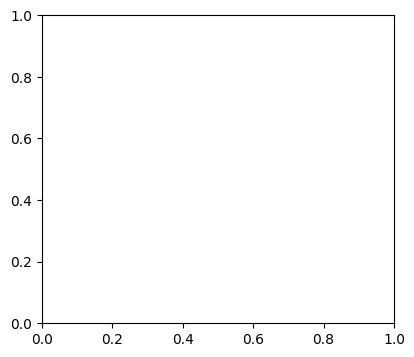

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

## Model Evaluation

# Future Work

# Observation & Recommendation

# Conclusion